In [1]:
import bls_cpu as gbls
from utils_python import mcmcroutines as mcmc
import utils_python.transitmcmc as tmcmc
import utils_python.transitplot as transitp
import utils_python.transitfit as transitf
import utils_python.transitmodel as transitm
import utils_python.keplerian as kep
import transitPy5 as tpy5
import transitfit5 as tfit5
import numpy as np
from exotic_ld import StellarLimbDarkening
import matplotlib.pyplot as plt

/home/aroy/venv/lib/python3.13/site-packages/exotic_ld/ld_grids.py:4: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  import pkg_resources


In [12]:
# Get the data file
datadir = "/data2/rowe/Kepler/Kepler_n/koi137.n/"
datafile1 = "klc08644288.dc.dat"
datafile2 = "tremove.1.dat"
datafile3 = "tremove.3.dat"

# Read it
phot = tpy5.readphot(datadir + datafile1)
phot2 = tpy5.readphot(datadir + datafile2)
phot3 = tpy5.readphot(datadir + datafile3)

zerotime = 54900

# Read in TTVs
ttv_files = [datadir + "koi0137.02.tt", datadir + "koi0137.01.tt", datadir + "koi0137.03.tt"]
ntt, tobs, omc = tfit5.readtt(ttv_files)

freqs:  0.001360135325090231 2.0
nstep:  969913


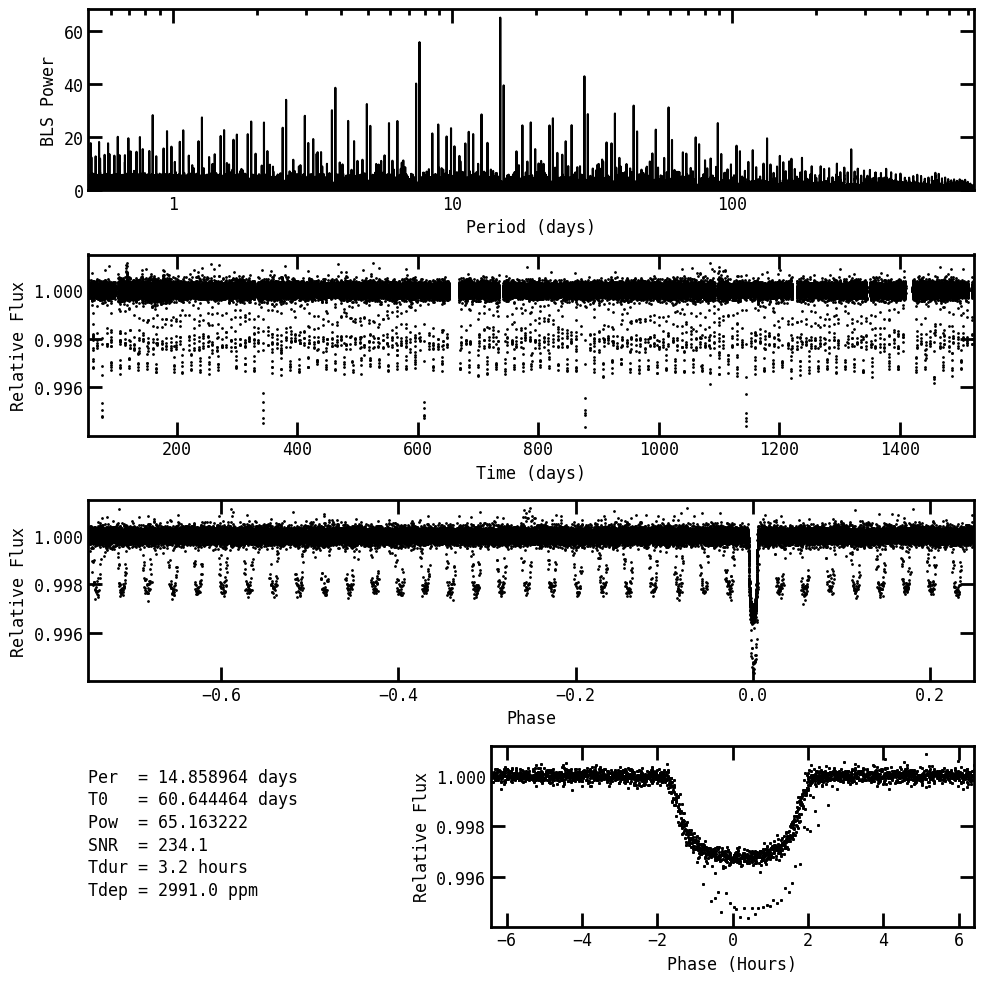

freqs:  0.001364953319483039 2.0
nstep:  201765


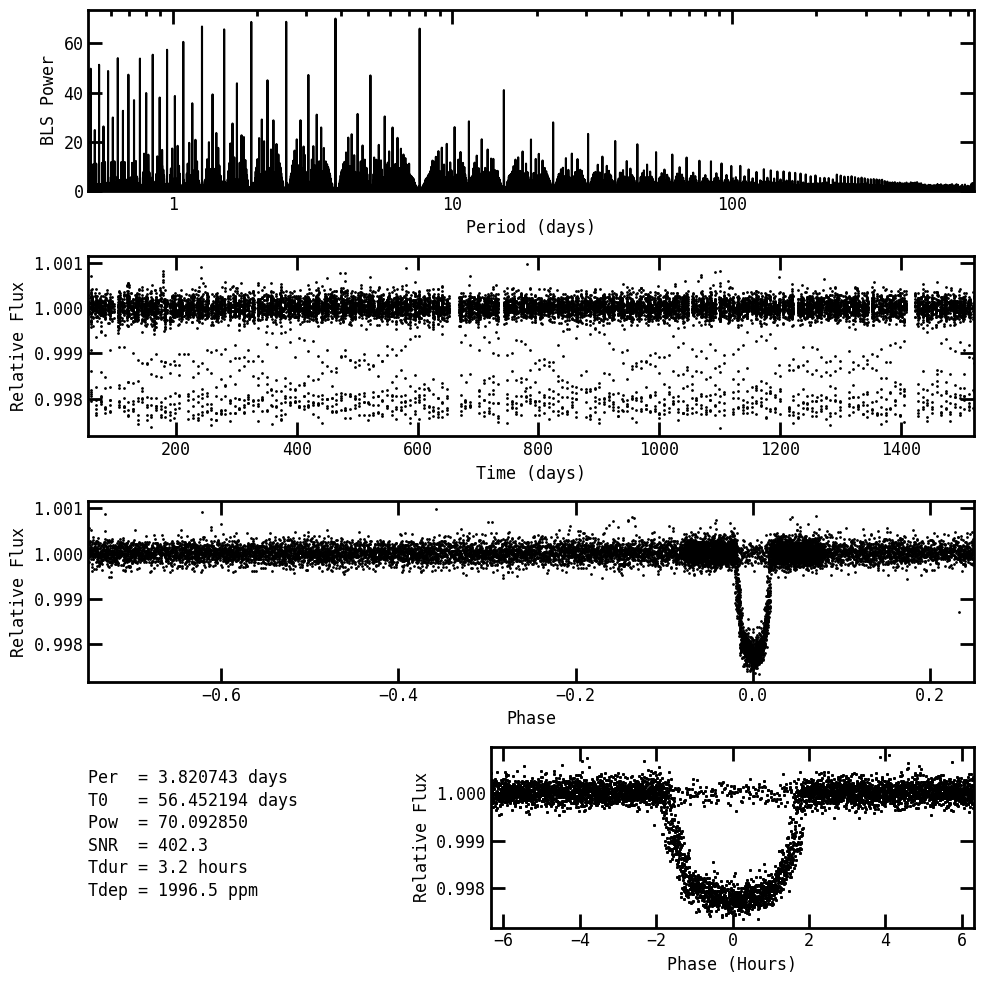

freqs:  0.001364953319483039 2.0
nstep:  201765


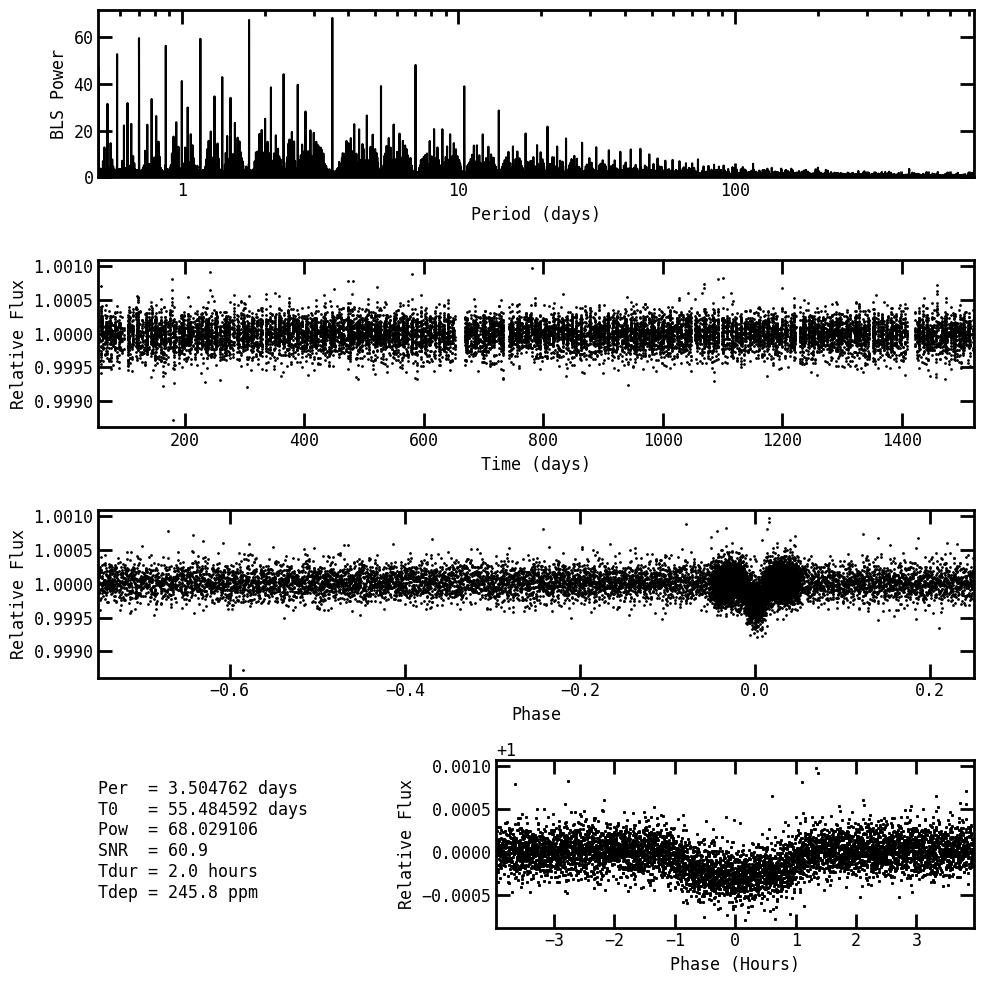

In [3]:
# BLS
gbls_inputs = gbls.gbls_inputs_class()
gbls_inputs.zerotime = zerotime
gbls_ans1 = gbls.bls(gbls_inputs, phot.time[phot.icut == 0], phot.flux[phot.icut == 0])

gbls_ans2 = gbls.bls(gbls_inputs, phot2.time[phot2.icut == 0], phot2.flux[phot2.icut == 0])

gbls_ans3 = gbls.bls(gbls_inputs, phot3.time[phot3.icut == 0], phot3.flux[phot3.icut == 0])

In [13]:
# Create an initial guess for all 18 parameters
sol = transitm.transit_model_class() # Single planet model has up-to 18-model parameters
sol.rho = kep.rhostar(gbls_ans1.bper, gbls_ans1.tdur)    # Mean stellar density (g/cm^3)
sol.nl1 = 0.0    # Only used for non-linear limb-darkening
sol.nl2 = 0.0    # Only used for non-linear limb-darkening
sol.dil = 0.0    # dilution
sol.vof = 0.0    # Velocity offset
sol.zpt = 0.0       # Photometric zero point
sol.t0  = [gbls_ans1.epo, gbls_ans2.epo + gbls_ans2.bper, gbls_ans3.epo]             # Center of transit time (days)
sol.per = [gbls_ans1.bper, gbls_ans2.bper*2, gbls_ans3.bper]            # Orbital Period (days)
sol.bb  = [0.5, 0.5, 0.5]                      # Impact parameter
sol.rdr = [np.sqrt(gbls_ans1.depth), np.sqrt(gbls_ans2.depth), np.sqrt(gbls_ans3.depth)]  # Rp/R*
sol.ecw = [0.0, 0, 0]  # sqrt(e)cos(w)
sol.esw = [0.0, 0, 0]  # sqrt(e)sin(w)
sol.krv = [0.0, 0, 0]  # RV amplitude (m/s)
sol.ted = [0.0, 0, 0]  # thermal eclipse depth (ppm)
sol.ell = [0.0, 0, 0]  # Ellipsodial variations (ppm)
sol.alb = [0.0, 0, 0]  # Albedo amplitude (ppm)
sol.npl = 3         # Number of planets

# Find Kipping limb-darkening coefficients
M_H = 0.2
Teff = 5400
logg = 4.45

ld_data_path = '/data2/rowe/exotic_ld_data/'
ld_model = 'mps1'
sld = StellarLimbDarkening(M_H, Teff, logg, ld_model, ld_data_path)
ld, ld_sig = sld.compute_kipping_ld_coeffs(wavelength_range=[0.6*10000, 1.0*10000], mode="TESS", mu_min=0.1, return_sigmas=True)
sol.nl3 = ld[0]
sol.nl4 = ld[1]

In [14]:
phot.ferr = np.full(len(phot.flux), np.std(phot.flux))
phot.time -= zerotime

In [15]:
# Define the parameters to fit
params_to_fit = ["rho", "zpt", "t0", "per", "bb", "rdr"]

# Fit the data
sol_fit = transitf.fitTransitModel(sol, params_to_fit, phot, ntt=ntt, tobs=tobs, omc=omc)

In [16]:
# Plotting
transitp.printParams(sol_fit)

ρ* (g/cm³):                     0.9102188 ± 0.1987461
c1:                                   0.0 ± 0.0
c2:                                   0.0 ± 0.0
q1:                             0.3545084 ± 0.0000000
q2:                             0.3205229 ± 0.0000000
Dilution:                             0.0 ± 0.0
Velocity Offset:                      0.0 ± 0.0
Photometric zero point:         1.227e-05 ± 1.696e-06

Planet #1:
t0 (days):                     60.6548189 ± 0.0005894
Period (days):                 14.8589092 ± 0.0000103
Impact parameter:               0.7751446 ± 0.0383398
Rp/R*:                          0.0572334 ± 0.0009407
sqrt(e)cos(w):                        0.0 ± 0.0
sqrt(e)sin(w):                        0.0 ± 0.0
RV Amplitude (m/s):                   0.0 ± 0.0
Thermal eclipse depth (ppm):          0.0 ± 0.0
Ellipsoidal variations (ppm):         0.0 ± 0.0
Albedo amplitude (ppm):               0.0 ± 0.0

Planet #2:
t0 (days):                     60.2659379 ± 0.0005210
Period (da

## MCMC

In [17]:
nsteps1 = 10000 #total length of chain will be nwalkers*nsteps
nsteps2 = 50000#200000 #nstep1 is to check that MCMC is okay, nstep2 is the real work.
nsteps_inc = 50000#100000
burninf=0.5 #burn-in for evalulating convergence
niter_cor=5000
burnin_cor=1000
nthin=101
nloopmax=5
converge_crit=1.02 #Convergence criteria
buf_converge_crit=1.2 #Convergence criteria for buffer

In [18]:
# Bring up the data to have median around 1
phot.flux += 1
if np.rint(np.median(phot.flux)) != 1:
    raise ValueError

# Generate input for mcmc
lnprob, x, beta = tmcmc.genmcmcInput(sol_fit, params_to_fit)
sol_a = sol_fit.to_array()
serr = sol_fit.err_to_array()

# Cut out of transit
phot_cut = tmcmc.cutOutOfTransit(sol_fit, phot)

params = [nsteps1, nsteps2, nsteps_inc, burninf, niter_cor, burnin_cor, nthin, nloopmax, converge_crit, buf_converge_crit]

In [ ]:
%%capture output
chain, accept, burnin = tmcmc.demcmcRoutine(x, beta, phot_cut, sol_a, serr, params, lnprob, ntt=ntt, tobs=tobs, omc=omc)

In [25]:
print(output.stdout)

runtest: [5.17539430e-04 4.14588038e-04 1.17791229e-05 5.07907132e-06]
Current Acceptance:  [0.03914591 0.85467128 0.48639456 0.49442379 0.07142857 0.25795053
 0.51750973 0.46381579 0.04923077 0.25263158 0.47916667 0.46979866
 0.37179487 0.61454545]
Current Acceptance:  [0.12703583 0.5087108  0.3754386  0.31864407 0.11397059 0.25795053
 0.3046595  0.32971014 0.13770492 0.25263158 0.30612245 0.31487889
 0.29770992 0.31386861]
Current Acceptance:  [0.27627628 0.1590106  0.20848057 0.16666667 0.24096386 0.25795053
 0.2398524  0.22463768 0.37728938 0.25263158 0.17567568 0.17667845
 0.19935691 0.16117216]
Current Acceptance:  [0.27627628 0.1        0.17586207 0.15068493 0.24096386 0.25795053
 0.2398524  0.22463768 0.45955882 0.25263158 0.2        0.16197183
 0.17627119 0.1316726 ]
Current Acceptance:  [0.27627628 0.12714777 0.15241636 0.21708185 0.24096386 0.25795053
 0.2398524  0.22463768 0.3161512  0.25263158 0.21923077 0.21824104
 0.2715655  0.21146953]
Current Acceptance:  [0.27627628 0

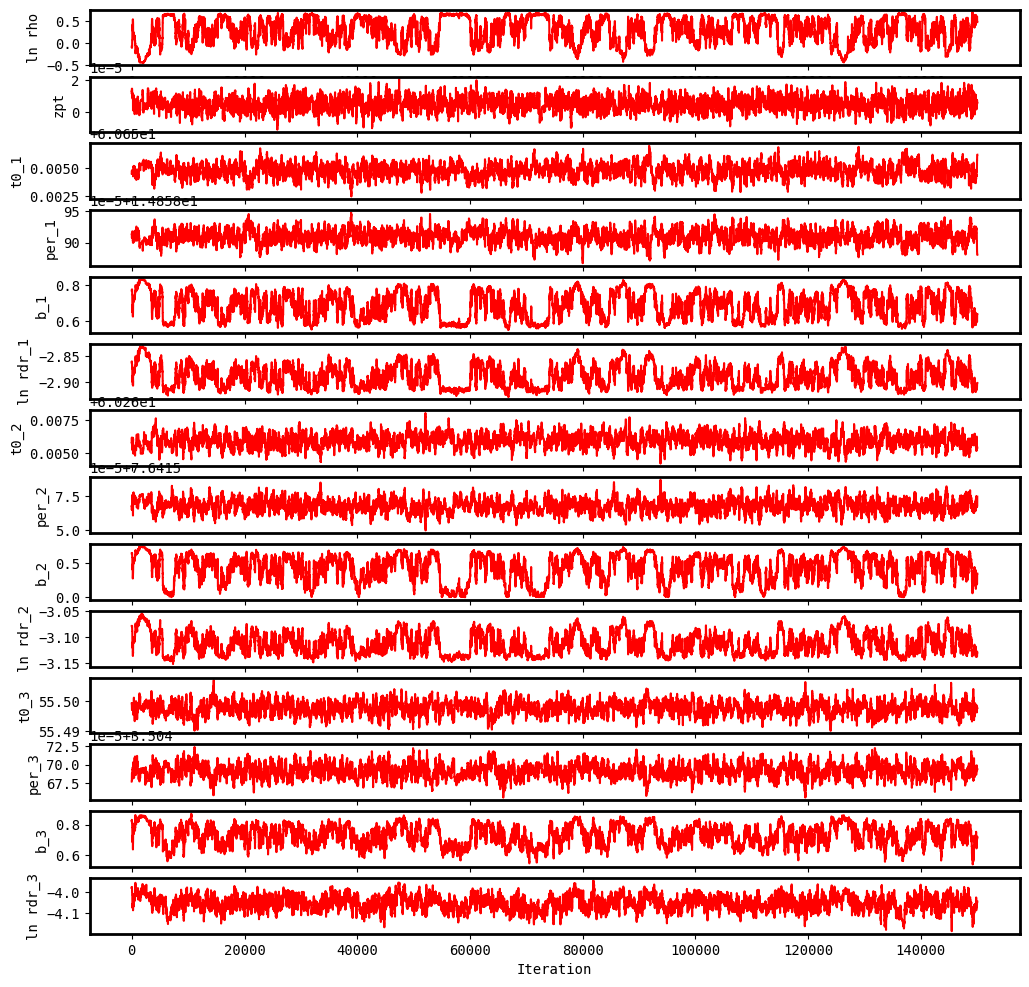

In [26]:
label = ["ln rho", "zpt", "t0_1", "per_1", "b_1", "ln rdr_1", "t0_2", "per_2", "b_2", "ln rdr_2", "t0_3", "per_3", "b_3", "ln rdr_3"]
color = ["red"]*14

plt.rcParams['font.size'] = 10
mcmc.plotchains(chain, label, color, burnin)

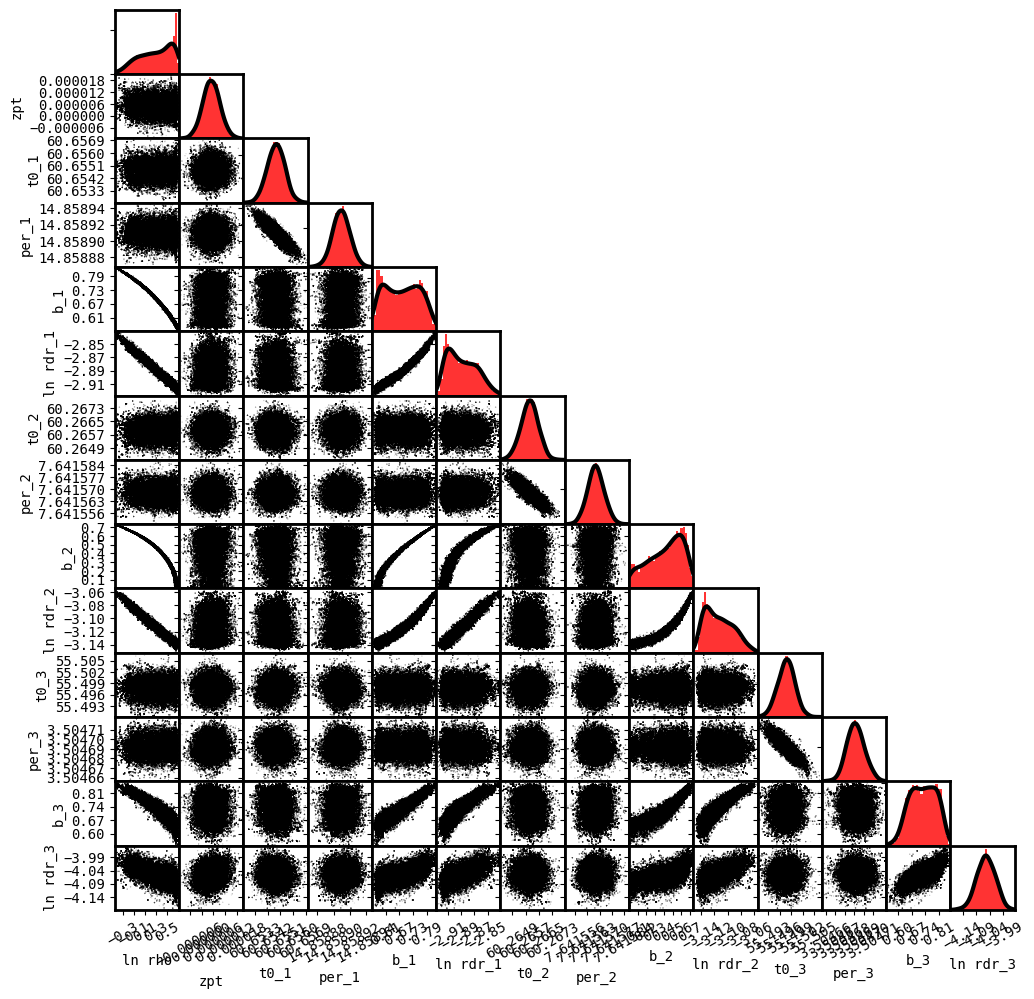

In [27]:
plt.rcParams['font.size'] = 10
mcmc.triplot(chain, burnin, label, color, 30)

In [28]:
sol_mcmc = tmcmc.getParams(chain, burnin, sol, params_to_fit)
transitp.printParams(sol_mcmc)

ρ* (g/cm³):                     1.3850815 ± 0.4045123
c1:                                   0.0 ± 0.0
c2:                                   0.0 ± 0.0
q1:                             0.3545084 ± 0.0000000
q2:                             0.3205229 ± 0.0000000
Dilution:                             0.0 ± 0.0
Velocity Offset:                      0.0 ± 0.0
Photometric zero point:         4.937e-06 ± 4.266e-06

Planet #1:
t0 (days):                     60.6547977 ± 0.0006148
Period (days):                 14.8589095 ± 0.0000106
Impact parameter:               0.6847034 ± 0.0732346
Rp/R*:                          0.0555229 ± 0.0011884
sqrt(e)cos(w):                        0.0 ± 0.0
sqrt(e)sin(w):                        0.0 ± 0.0
RV Amplitude (m/s):                   0.0 ± 0.0
Thermal eclipse depth (ppm):          0.0 ± 0.0
Ellipsoidal variations (ppm):         0.0 ± 0.0
Albedo amplitude (ppm):               0.0 ± 0.0

Planet #2:
t0 (days):                     60.2659495 ± 0.0005114
Period (da

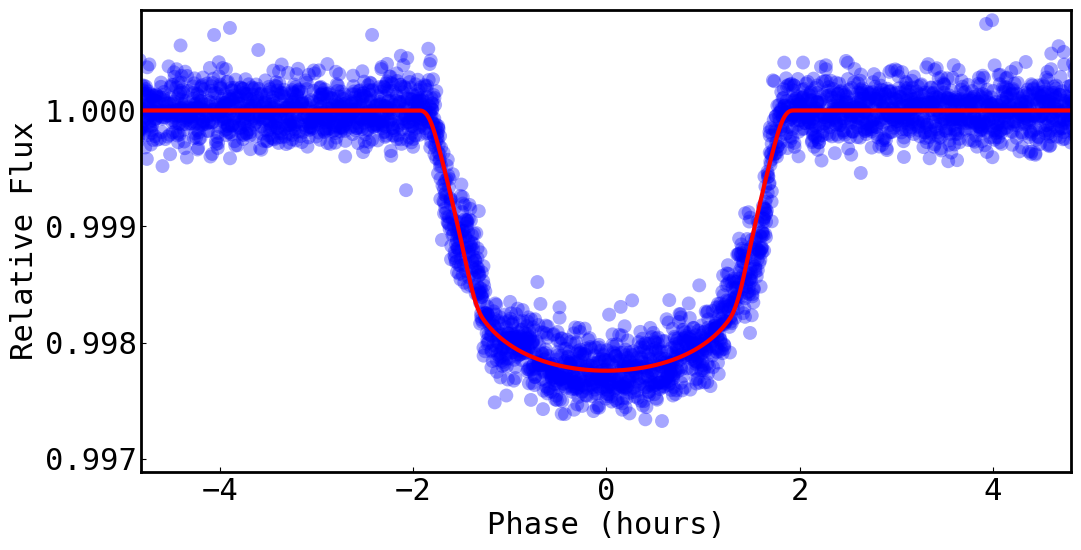

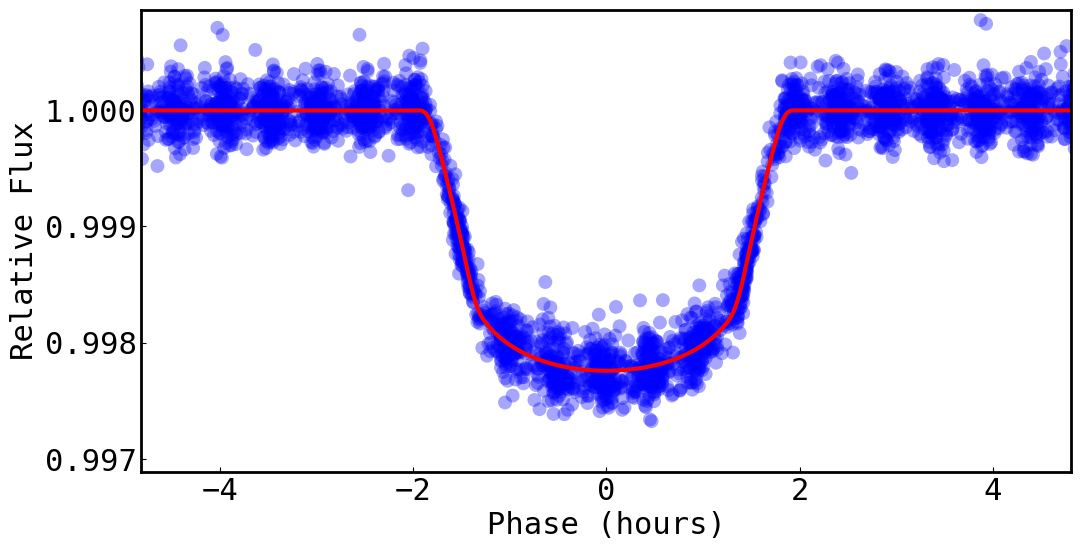

In [30]:
pl_plot = 2

transitp.plotTransit(phot, sol_mcmc, pl_to_plot=pl_plot)
transitp.plotTransit(phot, sol_mcmc, pl_to_plot=pl_plot, ntt=ntt, tobs=tobs, omc=omc)